# ASA Real Estate Data EDA & Insights

This notebook explores the synthetic dataset generated for ASA Real Estate. It demonstrates the relational structure between Properties, Units, and Tenants, and provides visualizations to understand the market dynamics we are simulating.

## 1. Variable Definitions (Data Dictionary)

### Properties Table (`calibrated_properties.csv`)
| Variable | Type | Definition |
|----------|------|------------|
| `property_id` | String | Unique Key (FK in Units). Format: `PROP_XXX` |
| `name` | String | Name of the building/complex |
| `neighborhood` | String | Geo-location cluster (e.g., Tribeca, Harlem) |
| `class` | Char | Asset Class (A=Luxury/New, B=Standard, C=Older/Value) |

### Units Table (`calibrated_units.csv`)
| Variable | Type | Definition |
|----------|------|------------|
| `unit_id` | String | Unique Key (FK in Tenants). Format: `PROP_XXX_UXXX` |
| `property_id` | String | Foreign Key linking to Properties table |
| `type` | String | Bedroom count (Studio, 1BD, 2BD, 3BD) |
| `amenities` | String | List of features (Gym, Doorman, View) |
| `sqft` | Int | Square footage of the unit |
| `market_rent` | Int | Monthly rent price ($) |

### Tenants Table (`calibrated_tenants.csv`)
| Variable | Type | Definition |
|----------|------|------------|
| `tenant_id` | String | Unique ID for the resident |
| `unit_id` | String | Foreign Key linking to which unit they lease |
| `name` | String | Full name of the tenant |
| `income` | Int | Annual household income ($). Core metric for Affordability ratios. |
| `credit_score` | Int | FICO score (300-850). Core metric for Risk profiling. |
| `lease_start` | Date | When the current lease began. Used for Renewal logic. |

In [2]:
pip install pandas matplotlib seaborn

  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:-

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")

## 2. Load Data

In [4]:
base_path = r"../src/data/synthetic/"

props = pd.read_csv(base_path + "calibrated_properties.csv")
units = pd.read_csv(base_path + "calibrated_units.csv")
tenants = pd.read_csv(base_path + "calibrated_tenants.csv")

print(f"Loaded {len(props)} Properties")
print(f"Loaded {len(units)} Units")
print(f"Loaded {len(tenants)} Tenants")

Loaded 30 Properties
Loaded 1836 Units
Loaded 1695 Tenants


## 3. Relational Joins
We denormalize the tables into a single `Master_DF` to analyze connections (e.g., Does Building Class affect Tenant Income?)

In [5]:
# Join Units -> Properties
units_props = units.merge(props, on='property_id', how='left')

# Join Tenants -> Units_Props
master_df = tenants.merge(units_props, on='unit_id', how='left')

master_df.head()

,tenant_id,unit_id,name_x,income,credit_score,lease_start,property_id,type,amenities,sqft,market_rent,name_y,neighborhood,class
0,cf398c83,PROP_000_U000,Lori Perez,110852,623,2024-07-10,PROP_000,2BD,[],1027,2124,Rodriguez Towers,Upper East Side,B
1,bea49c7b,PROP_000_U001,Kathryn Jimenez,171416,704,2025-07-02,PROP_000,2BD,"['Laundry', 'View', 'Gym', 'Doorman']",929,4046,Rodriguez Towers,Upper East Side,B
2,a4c85386,PROP_000_U003,Shawn Johnson,365167,730,2025-01-17,PROP_000,3BD,['Gym'],1399,10616,Rodriguez Towers,Upper East Side,B
3,0fcc6c71,PROP_000_U004,James Ortiz,171832,672,2025-12-28,PROP_000,Studio,[],454,3954,Rodriguez Towers,Upper East Side,B
4,d5828fae,PROP_000_U005,Jessica Powell,245171,694,2024-03-11,PROP_000,1BD,['Laundry'],737,5829,Rodriguez Towers,Upper East Side,B


## 4. EDA & Insights

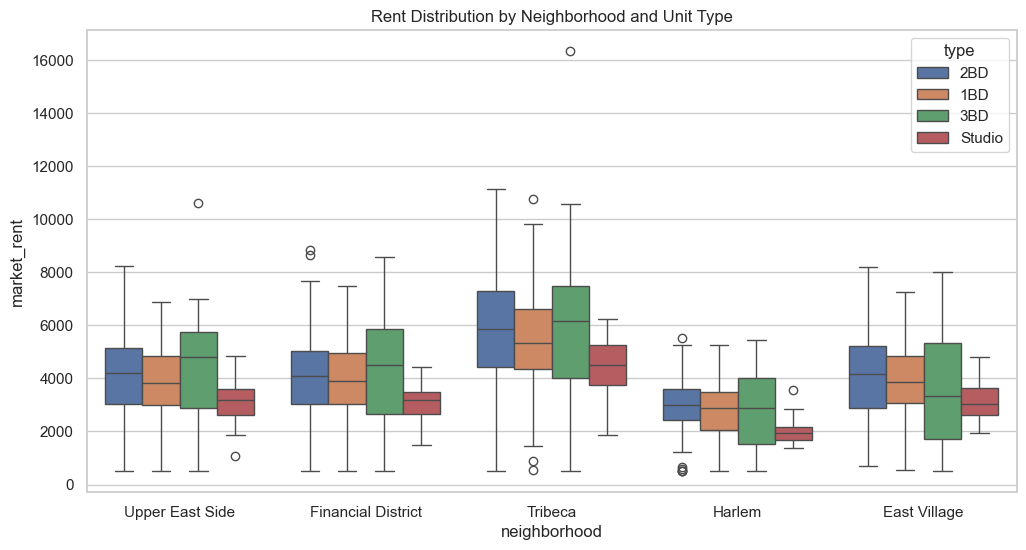

In [6]:
# Insight 1: Rent Distribution by Neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(data=units_props, x='neighborhood', y='market_rent', hue='type')
plt.title("Rent Distribution by Neighborhood and Unit Type")
plt.show()

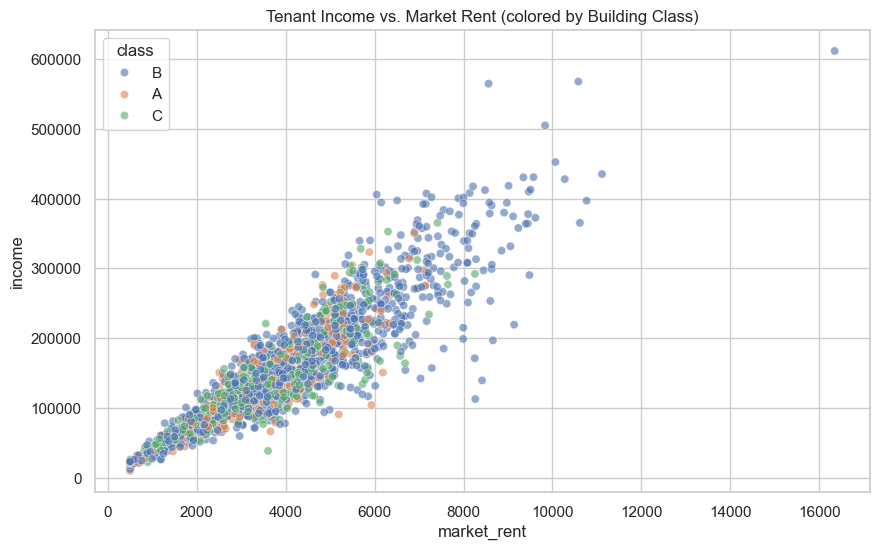

In [7]:
# Insight 2: Income vs Rent (Affordability)
# Calculating Rent-to-Income Ratio
master_df['monthly_income'] = master_df['income'] / 12
master_df['rent_burden'] = master_df['market_rent'] / master_df['monthly_income']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=master_df, x='market_rent', y='income', hue='class', alpha=0.6)
plt.title("Tenant Income vs. Market Rent (colored by Building Class)")
plt.show()

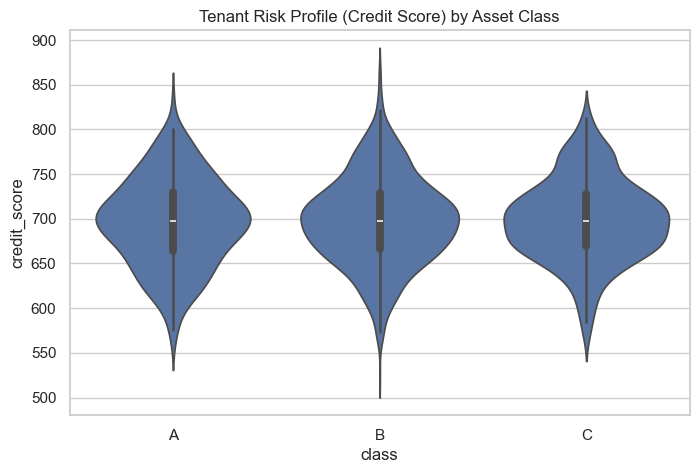

In [8]:
# Insight 3: Credit Score by Building Class
plt.figure(figsize=(8, 5))
sns.violinplot(data=master_df, x='class', y='credit_score', order=['A', 'B', 'C'])
plt.title("Tenant Risk Profile (Credit Score) by Asset Class")
plt.show()

## 5. Summary Statistics
Key metrics to validate our synthetic engine.

In [ ]:
summary = master_df.groupby(['neighborhood', 'type']).agg({
    'market_rent': 'mean',
    'income': 'mean',
    'credit_score': 'mean',
    'rent_burden': 'mean'
}).round(2)

summary

market_rent     income  credit_score  rent_burden
neighborhood       type                                                     
East Village       1BD         3843.06  153758.80        697.36         0.31
                   2BD         4162.90  170107.85        701.03         0.30
                   3BD         3529.78  136655.65        694.84         0.31
                   Studio      3160.15  125187.18        696.16         0.31
Financial District 1BD         3950.33  153242.20        693.38         0.32
                   2BD         4032.60  162515.90        700.84         0.31
                   3BD         4428.95  177835.00        711.20         0.32
                   Studio      3129.51  123033.30        699.24         0.32
Harlem             1BD         2863.93  112252.83        687.55         0.32
                   2BD         2896.85  115099.03        694.20         0.31
                   3BD         2936.70  103065.80        716.20         0.37
                   Studio      2041.11   80514.75        716.43         0.31
Tribeca            1BD         5541.34  225615.47        696.95         0.31
                   2BD         5850.01  234273.13        695.05         0.32
                   3BD         6135.35  240459.85        690.21         0.32
                   Studio      4546.21  177846.67        707.20         0.32
Upper East Side    1BD         3808.22  150264.21        703.12         0.32
                   2BD         4111.02  163864.96        692.94         0.32
                   3BD         4196.66  172377.31        699.03         0.31
                   Studio      3087.03  121534.54        693.90         0.32

: 